### Decision Tree Regression auf dem Ames Housing Price Data Set von kaggle.com

Einmalige Installation notwendiger Pakete wird in VL 3 beschrieben. 

#### Versionsgeschichte

- 1.0 21.05.2023 Willi Hahn Initialversion
- 1.3 21.10.2023 Willi Hahn Datenvorbereitung nach Ames EDA.ipynb ausgelagert.
- 1.4 21.07.2024 Willi Hahn GridSearchCV, Plot mit dtreeviz angefügt. Deprecated Medlungen rückgebaut.
- 1.5 13.08.2024 Willi Hahn update fixes RMSE für Bokeh
- 1.6 15.07.2025 Willi Hahn Anpassung Pfade auf github, logging mit Datendatei erweitert.

In [1]:
# notwendige Bibliotheken importieren und konfigurieren
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #Plot Bibliothek
import seaborn as sns #importing Seaborn's for plots
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree # Ausgabe des Entscheidungsbaums
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from timeit import default_timer as timer

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool, LassoSelectTool, Plot, WheelZoomTool, BoxZoomTool, ResetTool
output_notebook(resources=None, verbose=True, hide_banner=True)

# workaround für manchmal verschwindende Anzeige von Zellen in Standard Jupyter (nicht in Jupyterlab), Stand 07/2025
from IPython.display import display, HTML

display(HTML("""
<style>
div.output_scroll {
    overflow-y: auto;
    max-height: 500px;
}
</style>
"""))


scriptname='Ames Dec Tree.ipynb'
logtext=""
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(
    force=True,
    level=logging.INFO,
    format="%(asctime)s;%(levelname)s;%(message)s;",
    datefmt="%Y-%m-%d %H:%M:%S",
    encoding='utf-8',
    filemode='a',
    filename="AllScripts.log" # Default ist append
)
logger = logging.getLogger()



In [6]:

# Daten einlesen
file_ames_cleaned = 'c:/myBox/Projekte/python/Ames_Cleaned_26_v1.csv'# für lokale Dateien
#file_ames_cleaned = 'https://raw.githubusercontent.com/WilliHahn/FHDW/main/Ames_Cleaned_26_v1.csv' # Stand 07/2025
datendateiname = os.path.basename(file_ames_cleaned)
df = pd.read_csv(file_ames_cleaned, sep=',') 

# Originaldaten einlesen für EDA der Vorhersagen
file_ames_org = 'c:/myBox/Projekte/python/Daten/Ames/AmesHousing.csv' # für lokale Dateien
#file_ames_org = 'https://raw.githubusercontent.com/WilliHahn/FHDW/main/AmesHousing.csv'
df_org= pd.read_csv(file_ames_org, sep=',') 


In [8]:
# Trainings- und Testdaten aufteilen
TESTANTEIL = 0.25 # Split der Test- und Trainingsdaten
RANDOM_STATE=42
# Trennung von unabhängigen Variablen und abhängiger Zielvariable
y = df['SalePrice']
x = df.drop(['SalePrice'], axis = 1)
#x.head().T
#y.head().T

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TESTANTEIL, random_state=RANDOM_STATE)
df_test = pd.DataFrame()
df_test = pd.concat ([x_test, y_test], axis=1) 
#print (df_test)
x_test.drop(columns=['Order'], inplace=True, axis=1) # jetzt erst eindeutigen Primärschlüssel entfernen
x_train.drop(columns=['Order'], inplace=True, axis=1) 
# und prüfen durch ansehen
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)
#print (dfx_test.info(verbose=True))


(2017, 26) (2017,) (673, 26) (673,)


In [14]:
# Modellerstellung DecisionTreeRegressor

CRITERION= 'squared_error'  # default squared_error
MAX_DEPTH=  7 # default None, best gridsearchCV 6
MAX_FEATURES= None # default None, best gridsearchCV 
MAX_LEAF_NODES=  60 # default None, best gridsearchCV 60
MIN_SAMPLES_LEAF=  12 # default 1, best gridsearchCV 12
MIN_SAMPLES_SPLIT=  2 # default 2, best gridsearchCV 2
SPLITTER= 'best' # default best, random, best gridsearchCV best
RANDOM_STATE=42 # default None

t0 = timer()
dt = DecisionTreeRegressor(criterion=CRITERION, max_depth=MAX_DEPTH, max_features=MAX_FEATURES, 
            max_leaf_nodes=MAX_LEAF_NODES, min_samples_leaf=MIN_SAMPLES_LEAF, min_samples_split=MIN_SAMPLES_SPLIT,
            splitter=SPLITTER)
dt.fit(x_train, y_train);
y_pred = dt.predict(x_test)
t1 = timer()
print ('Laufzeit DecisionTreeRegressor = ', round(t1 - t0, 0), ' sec')


mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test,y_pred) 
r2 = r2_score(y_test,y_pred)
adjusted_r2 = 1 - (1-r2)*(len(y_pred)-1)/(len(y_pred)-x_test.shape[1]-1)
print("MAE = "+ f'{mae:0.0f}')
print("RMSE = "+ f'{rmse:0.0f}')
print('Model Score R2 = 'f'{r2:0.2f}')
print('Model Score R2 Adjusted = ' + f'{adjusted_r2:0.2f}')

logging.info(scriptname + "; Data Frame: " +str(df.shape[0])+ ";"+ str(df.shape[1])+ 
             "; Testanteil: "+ f'{TESTANTEIL:9.2f}'+ "; Seed: " + f'{RANDOM_STATE:9.0f}'+ ";")
logging.info(scriptname + ';' + CRITERION + 
             ";" + str(MAX_DEPTH) + ";" + str(MAX_FEATURES) + ";"+ str(MAX_LEAF_NODES)+ 
             ";" + str(MIN_SAMPLES_LEAF)+ ";" + SPLITTER+ ";" + f'{MIN_SAMPLES_SPLIT:3.0f}'+ ";")
logging.info(scriptname + '; MAE=' + f'{mae:0.0f}' + "; RMSE=" + f'{rmse:0.0f}'+ "; R2=" + f'{r2:0.2f}'+ "; R2 adj.="+ 
             f'{adjusted_r2:0.2f}'+ ";")


Laufzeit DecisionTreeRegressor =  0.0  sec
MAE = 23620
RMSE = 35720
Model Score R2 = 0.80
Model Score R2 Adjusted = 0.79


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673 entries, 0 to 672
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Order                673 non-null    int64  
 1   Bsmt Qual            673 non-null    float64
 2   Exter Qual           673 non-null    int64  
 3   Fireplace Qu         673 non-null    float64
 4   Functional           673 non-null    int64  
 5   Garage Area          673 non-null    int64  
 6   Garage Qual          673 non-null    float64
 7   Gr Liv Area          673 non-null    int64  
 8   HouseAge             673 non-null    int64  
 9   TotalPorchSF         673 non-null    int64  
 10  Kitchen Qual         673 non-null    int64  
 11  Land Contour         673 non-null    int64  
 12  Lot Area             673 non-null    int64  
 13  Lot Frontage         673 non-null    float64
 14  Lot Shape            673 non-null    int64  
 15  Mas Vnr Area         673 non-null    flo

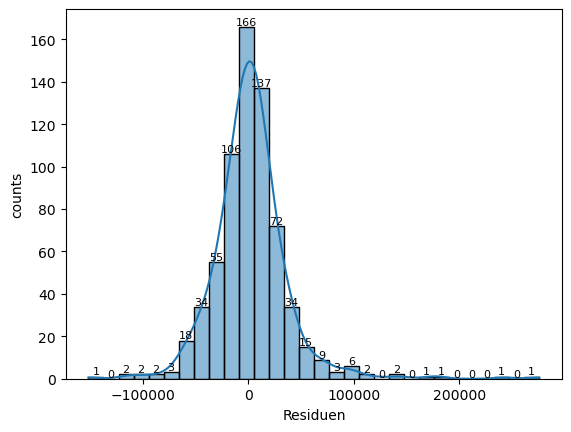


Vorhersagen mit Fehler <= -100000


,Order,Bsmt Qual_left,Exter Qual_left,Fireplace Qu_left,Functional_left,Garage Area_left,Garage Qual_left,Gr Liv Area_left,HouseAge,TotalPorchSF,...,Pool Area,Pool QC_right,Fence,Misc Feature,Misc Val_right,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice_right
112,2446,4.0,1,2.5,7,807,3.0,3627,11,437,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
146,66,3.0,1,4.0,7,666,3.0,3238,15,369,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,410000
221,350,4.0,1,3.0,7,564,3.0,2522,5,239,...,0,NaN,NaN,NaN,0,11,2009,WD,Normal,375000
229,2738,2.5,0,3.0,7,836,3.0,3672,71,796,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,415000
320,1538,2.5,0,3.0,7,1014,3.0,3447,73,326,...,0,NaN,GdWo,NaN,0,5,2008,WD,Normal,381000
383,2098,4.0,1,2.5,7,1052,3.0,2828,1,269,...,0,NaN,NaN,NaN,0,4,2007,New,Partial,424870
395,1638,4.0,4,3.0,7,1110,4.0,2338,1,457,...,0,NaN,NaN,NaN,0,6,2007,New,Partial,591587
410,2331,4.0,4,4.0,7,758,3.0,3390,0,238,...,0,NaN,NaN,NaN,0,9,2006,New,Partial,545224
491,1641,3.0,1,3.0,7,567,3.0,1419,0,140,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,392000



Vorhersagen mit Fehler >= 100000


,Order,Bsmt Qual_left,Exter Qual_left,Fireplace Qu_left,Functional_left,Garage Area_left,Garage Qual_left,Gr Liv Area_left,HouseAge,TotalPorchSF,...,Pool Area,Pool QC_right,Fence,Misc Feature,Misc Val_right,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice_right
277,2104,4.0,1,3.0,7,868,3.0,2574,0,148,...,0,NaN,NaN,NaN,0,11,2007,New,Partial,276000
418,2750,3.0,1,0.0,7,920,3.0,1440,13,288,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,224500
494,1063,4.0,1,3.0,7,756,3.0,2332,4,366,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,316000
516,2462,4.0,1,3.0,7,792,3.0,2640,0,265,...,0,NaN,NaN,NaN,0,11,2006,New,Partial,405749


In [19]:
# Verteilungen für wirklichen und vorhergesagten Verkaufspreisen berechnen und vergleichen

df_test.index = pd.RangeIndex(len(df_test.index)) # neue Indexnumerierung für concat mit y_pred
df_comparison = pd.concat ([df_test, pd.DataFrame({"Predicted":y_pred})], axis=1) 
df_comparison['Diff'] = df_comparison['Predicted'] - df_compare['SalePrice'] 
df_comparison.info()
#print('df_comparison: \n', df_comparison.shape, '\n', df_comparison)
y = sns.histplot(data=y_test - y_pred, bins=30, stat='count', element="bars", kde=True)
_ = y.bar_label(y.containers[0], fontsize = 8) # Beschriftung der bins. deswegen seaborn.
y.set(xlabel='Residuen', ylabel='counts')
_ = plt.show()

# Für Tabellenanzeige bei EDA hier konkattenieren der Originaldatern 
df_c2=pd.merge(df_compare, df_org, left_on='Order', right_on='Order', how='left', suffixes=('_left', '_right') )
#print (df_c2.info(verbose=True))
#print ('\n df_c2\n', df_c2[["Order", "SalePrice_left", "SalePrice_right"]].loc[df_c2["Order"] == 1457])  # Testdatensatz SalePrice  230500
#print ('\n df_c2\n', df_c2[["Order", "SalePrice_left", "SalePrice_right"]].loc[df_c2["Order"] == 2435])  # Testdatensatz SalePrice  230500

print ("\nVorhersagen mit Fehler <= -100000")
display(df_c2.loc[df_c2["Diff"] <= -100000  ] )
print ("\nVorhersagen mit Fehler >= 100000")
display(df_c2.loc[df_c2["Diff"] >= 100000  ])

In [16]:
# Scatterplot für wahre Hauspreise gegen Vorhersagen, mit tool tips
# Explorative interaktive Graphik, um ungenaue Vorhersagen zu untersuchen.
#print (df_c2.info(verbose=True))

"""
12.08.2024 update incident wegen
BokehDeprecationWarning: 'circle() method with size value' was deprecated in Bokeh 3.4.0 and will be removed, use 'scatter(size=...) instead' instead.

"""

source = ColumnDataSource(df_c2)

hover = HoverTool(
        tooltips=[
            ("OrderNo", "@Order")
             , ("Sale Price Actual", "@SalePrice_left{0}")
             , ("Sale Price Predicted", "@Predicted{0}")
             , ("House Built", "@{Year Built}{0}")
             , ("House Remodel", "@{Year Remod/Add}{0}")
             , ("Lot Area", "@{Lot Area}{0}")
             , ("Liv Area above Ground", "@{Gr Liv Area_left}{0}")
             , ("TotalBathrooms", "@{TotalBathrooms}{0.0}")
             , ("Neighborhood", "@Neighborhood")
        ]
    )

p = figure(width=800, height=400, tools=[hover],
           title="Actual vs predicted Sale Price (see tool tip)", x_range=(0, 700000), y_range=(-200000, 200000),
           toolbar_location="right", toolbar_sticky=False)
p.add_tools(WheelZoomTool(), BoxZoomTool(), ResetTool())
p.xaxis.axis_label = 'Actual Sale Price'
p.yaxis.axis_label = 'Residual'
p.left[0].formatter.use_scientific = False
p.below[0].formatter.use_scientific = False
_ = p.scatter('SalePrice_left', 'Diff', size=10, source=source)
_ = show(p)

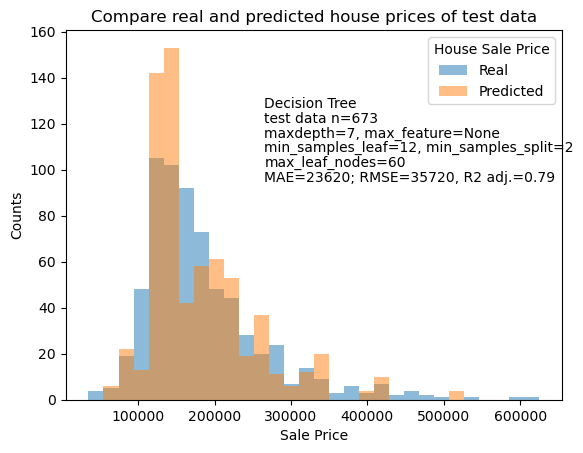

In [20]:
# Vergleich der Verteilungen für wirklichen und vorhergesagten Verkaufspreisen
# Über- oder unterschätzung? Sind alle Klassen abgedeckt?

fig, ax = plt.subplots(1)
min_value = min(df_comparison['SalePrice'].min(), df_comparison['Predicted'].min())
max_value = max(df_comparison['SalePrice'].max(), df_comparison['Predicted'].max())
bins = np.linspace(min_value, max_value, 31)  # 30 gleichmäßige Bins

plt.rcParams["figure.autolayout"] = True
_ = plt.hist(df_c2['SalePrice_left'],bins=bins, range=[0,700000], alpha=0.5)
_ = plt.xlabel('Sale Price');
_ = plt.text(0.4,0.79,"Decision Tree", transform = ax.transAxes)
_ = plt.text(0.4,0.75,"test data n=" + str (df_c2.shape[0]),color='black', transform = ax.transAxes)
_ = plt.text(0.4,0.71,"maxdepth=" + str (MAX_DEPTH) + ", max_feature=" + str (MAX_FEATURES),color='black', transform = ax.transAxes)
_ = plt.text(0.4,0.67,"min_samples_leaf=" + str (MIN_SAMPLES_LEAF) + ", min_samples_split=" + str (MIN_SAMPLES_SPLIT),color='black', transform = ax.transAxes)
_ = plt.text(0.4,0.63,"max_leaf_nodes=" + str (MAX_LEAF_NODES),color='black', transform = ax.transAxes)
_ = plt.text(0.4,0.59,'MAE=' + f'{mae:0.0f}' + "; RMSE=" + f'{rmse:0.0f}'+ ", R2 adj.="+ f'{adjusted_r2:0.2f}',color='black', transform = ax.transAxes)
_ = plt.hist(df_c2['Predicted'],bins=bins, range=[0,700000], alpha=0.5)
_ = plt.xlabel('Sale Price');
_ = plt.ylabel('Counts');
_ = plt.title('Compare real and predicted house prices of test data');
_ = plt.legend(title='House Sale Price', loc='upper right', labels=['Real', 'Predicted'])
plt.show()


            



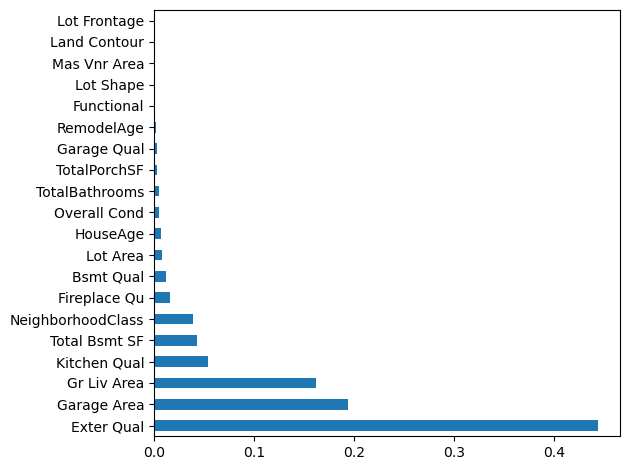

In [21]:
# Feature Importance
# Jeder Wert gibt an, wie stark ein Feature zur Reduktion der „Impurity“ (z. B. Gini, Entropie oder Varianz) im Baum beiträgt.
# Die Werte sind normalisiert, sodass ihre Summe 1 ergibt.
feat_importances = pd.Series(dt.feature_importances_, index=x_test.columns)
_ = feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
# Zelle Print Decision Tree
tree.plot_tree(dt)
plt.show()
print(tree.export_text(dt, feature_names=x_test.columns,max_depth=100, decimals=0))


In [ ]:
# Baumdarstellung mit Bibliothek dtreeviz
import dtreeviz 
from dtreeviz import model
# siehe https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_sklearn_visualisations.ipynb
# https://explained.ai/decision-tree-viz/index.html



%config InlineBackend.figure_format = 'retina'
#pip install -q dtreeviz auf python terminal oder !pip install -q dtreeviz in Colab
viz = dtreeviz.model(dt, x_train, y_train,
    target_name='SalePrice',
    feature_names=x_train.columns)

viz.view(scale=2, orientation="LR", title_fontsize=10, ticks_fontsize=10, label_fontsize=10, show_node_labels=True,
        fancy=True)


In [ ]:
# GridSearchCV DecisionTreeRegressor mit  zur Bestimmung optimaler Hyperparameter

# Untersuchung Hyperparameter 
# Achtung: Rechenzeit = (Anzahl kombinierter Parameter)
# Runde 1 mit "max_depth":[5,10,20,40,80,160] , "max_leaf_nodes":[50,200,400, 600, 1200]
# Runde 2 kleinere Abstände bei 5 bis 15 und um 50

def plot_gridsearch_results_V0 (grid):
    """
    Params: 
        grid: A trained GridSearchCV object. 
    What
        Plots generically all hyperparameter.
        GridSearchCV needs return_train_score=True.
        score for regression is R2, for classification accuracy(?)
        stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.0, 0.5, 'mean score', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        print ("x=",x, "y_1=",y_1)
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()
    #plt.savefig('GridsearchCV_results_DecTree.pdf')

# Wegen Rechenzeiten > 1 Std. sind die aufwendigen Optionen auskommentiert.
parameter_space = \
{
       "criterion":['squared_error'], #, 'squared_error', 'friedman_mse',  absolute_error
       "max_features": [10], # int, float or {“auto”, “sqrt”, “log2”}, default=None, [5,10,15,20,25,50,100]
       "splitter":["best"],  #, "random", "best"
       "max_depth": [10], #Default None, [2,4,5,6,7,8,9,10,11,25]
       "min_samples_split":[2], 
       "min_samples_leaf": [12], #list(range(3, 19, 3)),
       "max_leaf_nodes":[140],
       "random_state":[RANDOM_STATE]
   }
'''
Beste Hyperparameter =  {'criterion': 'squared_error', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 12, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
Beste Hyperparameter =  {'criterion': 'squared_error', 'max_depth': 12, 'max_features': 25, 'max_leaf_nodes': 120, 'min_samples_leaf': 9, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
'''
t0 = timer()
grid = GridSearchCV(DecisionTreeRegressor(random_state=42), parameter_space, 
                   cv=3, n_jobs=-1, return_train_score=True)
grid.fit(x_train, y_train)
t1 = timer()
print ('Laufzeit GridSearchCV = ', round(t1 - t0, 0), ' sec')
print('R squared = ' , grid.best_score_)
print('Beste Hyperparameter = ', grid.best_params_)
plot_gridsearch_results_V0(grid)

#display(pd.DataFrame(grid.cv_results_).head(3))



In [ ]:
# Test
viz.rtree_leaf_distributions(figsize=(5,3))
viz.leaf_sizes(figsize=(3.5,2))
